# **Libraries**

Install new libraries

In [1]:
libraries_to_install = {'umap-learn': 'umap'}

for library, alias in libraries_to_install.items():
    try:
        exec(f"import {alias}")
    except ImportError:
        !pip install {library} --quiet

In [2]:
import os
import torch
import scipy
import json
import time
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import umap
import warnings
from zipfile import ZipFile

import torch.optim as optim
import torch.nn.functional as F # Funciones matemáticas, activación, pérdida, normalización, etc.
from torch import nn
from torch.nn import Parameter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from multiprocessing import Pool
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from tensorflow import keras

warnings.filterwarnings("ignore", category=Warning)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


# **Model**

In [4]:
class LISV2_MLP(nn.Module):
    def __init__(self, data, device, args):
        super(LISV2_MLP, self).__init__()

        with torch.no_grad():
            self.device = device
            self.args = args
            self.cluster_centers = Parameter(torch.Tensor(args['n_cluster'], args['clu_dim']))

            self.n_points = data.shape[0]
            self.perplexity = args['perplexity']
            self.args['NetworkStructure'][0] = data.shape[1]
            self.NetworkStructure = args['NetworkStructure']
            self.data = data.float().to(self.device)

            self.epoch = 0
            self.vList = [100] + [1] * (len(args['NetworkStructure']) - 1)
            self.gammaList = self.CalGammaF(self.vList)

            print('start calculate sigma')
            dist = self.Distance_squared(data, data).float()
            rho, self.sigmaListlayer = self.InitSigmaSearchEverySample(self.gammaList, self.vList, data, dist)
            #print(rho)
            #print(self.sigmaListlayer)
            #.detach:  Desconecta el tensor del gráfico computacional.
            #.cpu:   Mueve el tensor a la memoria de la CPU.
            self.P = self.CalPt(dist, rho, self.sigmaListlayer[0].cpu(), gamma=self.gammaList[0], v=self.vList[0]).float().detach().to(self.device)

            # np.save("../InitDis/{}_InputDis_perplexity{}.npy".format(args['data_name'], args['perplexity']), self.P.detach().cpu().numpy())
            # self.P = torch.tensor(np.load("../InitDis/{}_InputDis_perplexity{}.npy".format(args['data_name'], args['perplexity']))).to(self.device)
            #np.savez('/content/drive/My Drive/arguments.npz', name1= dist.detach().cpu().numpy(), name2=rho, name3=self.sigmaListlayer[0].cpu().numpy(), name4=self.P.detach().cpu().numpy())
            s_out = np.log10(self.args['vtrace_out'][0])
            e_out = np.log10(self.args['vtrace_out'][1])
            self.vListForEpoch_out = np.concatenate([np.zeros((self.args['epochs']//2+1, )) + 10**s_out, np.logspace(s_out, e_out, self.args['epochs']//2)])

            s_in = np.log10(self.args['vtrace_in'][0])
            e_in = np.log10(self.args['vtrace_in'][1])
            self.vListForEpoch_in = np.concatenate([np.zeros((self.args['epochs']//2+1, )) + 10**s_in, np.logspace(s_in, e_in, self.args['epochs']//2)])

            print('start Init network')
            self.InitNetwork()

            torch.cuda.empty_cache()

    def InitNetwork(self, ):
        #módulos dentro nn.ModuleList se registran como submódulos del modelo principal, lo que garantiza que los parámetros de estos submódulos se incluyan en el proceso de optimización
        self.encoder = nn.ModuleList() #clase para almacenar un grupo de capas de manera ordenada. útil cuando se desea aplicar un conjunto de capas de manera secuencial dentro del método forward de tu modelo.
        for i in range(len(self.NetworkStructure) - 1):
            self.encoder.append(
                nn.Linear(self.NetworkStructure[i],
                          self.NetworkStructure[i + 1]))
            if i != len(self.NetworkStructure) - 2: #aplica una LeakyReLu excepto la ultima capa
                self.encoder.append(nn.LeakyReLU(0.1))

        self.decoder = nn.ModuleList()
        for i in range(len(self.NetworkStructure) - 1, 0, -1):
            self.decoder.append(
                nn.Linear(self.NetworkStructure[i],
                          self.NetworkStructure[i - 1]))
            if i != 1:
                self.decoder.append(nn.LeakyReLU(0.1))

    def CalGammaF(self, vList):

        out = []
        for v in vList:
            a = scipy.special.gamma((v + 1) / 2)
            b = np.sqrt(v * np.pi) * scipy.special.gamma(v / 2)
            out.append(a / b)

        return out

    def Distance_squared(self, x, y):

        m, n = x.size(0), y.size(0)
        xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
        yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
        dist = xx + yy
        dist.addmm_(1, -2, x, y.t())
        d = dist.clamp(min=1e-12)
        d[torch.eye(d.shape[0]) == 1] = 1e-12

        return d

    def InitSigmaSearchEverySample(self, gammaList, vList, data, dist):

        distC = torch.clone(dist)
        distC[distC.le(1e-11)] = 1e16
        rho, _ = torch.min(distC, dim=1)

        sigmaListlayer = [0] * len(self.args['NetworkStructure'])

        r = PoolRunner(self.n_points, self.perplexity, dist.detach().cpu().numpy(), rho.detach().cpu().numpy(), gammaList[0], vList[0])
        sigmaListlayer[0] = torch.tensor(r.Getout()).to(self.device)

        std_dis = torch.std(rho) / np.sqrt(data.shape[1])
        print('std', std_dis)

        if std_dis > 0.2:
            for i in range(1, len(self.args['NetworkStructure'])):
                sigmaListlayer[i] = torch.zeros(data.shape[0], device=self.device) + 1
        else:
            for i in range(0, len(self.args['NetworkStructure'])):
                sigmaListlayer[i] = torch.zeros(data.shape[0], device=self.device) + sigmaListlayer[0].mean() * 5

        return rho, sigmaListlayer

    def CalPt(self, dist, rho, sigma_array, gamma, v=100):

        if torch.is_tensor(rho):
            dist_rho = (dist - rho.reshape(-1, 1)) / sigma_array.reshape(-1, 1)
        else:
            dist_rho = dist
        dist_rho[dist_rho < 0] = 0

        Pij = torch.pow(gamma * torch.pow((1 + dist_rho / v), -1 * (v + 1) / 2) * torch.sqrt(torch.tensor(2 * 3.14)), 2)

        #symmetrization uij are confined in the range (0, 1), but their sum needs not to be 1 to be a probability distribution
        P = Pij + Pij.t() - torch.mul(Pij, Pij.t())

        return P

    def CE(self, P, Q):

        EPS = 1e-12
        #losssum1  is the sum of the differences between similarities weighted by P(X), which preserves the local geometry
        losssum1 = (P * torch.log(Q + EPS)).mean()
        #losssum2 is the sum of the differences between dissimilarities weighted by 1 − P(X) which preserves the global geometry.
        losssum2 = ((1-P) * torch.log(1-Q + EPS)).mean()
        losssum = -1 * (losssum1 + losssum2)

        if torch.isnan(losssum):
            input('stop and find nan')
        return losssum

    def Loss(self, latentList, input_data_index):

        Q0 = self.CalPt(dist=self.Distance_squared(latentList[0], latentList[0]), rho=0, sigma_array=1, gamma=self.gammaList[-1], v=self.vList[-1])
        Q1 = self.CalPt(dist=self.Distance_squared(latentList[1], latentList[1]), rho=0, sigma_array=1, gamma=self.gammaList[-2], v=self.vList[-2])
        #Geometry-Preserving loss
        loss_ce = self.CE(P=self.P[input_data_index][:, input_data_index],Q=Q0) * self.args['ratio'][0]
        if self.args['ratio'][1] > 0: #"ratio": [1.0, 0.0, 0.0, 0.01, 0.01],
            loss_ce += self.CE(P=self.P[input_data_index][:, input_data_index],Q=Q1) * self.args['ratio'][1]
        if self.args['ratio'][2] > 0:
            loss_ce += self.CE(P=Q1,Q=Q0) * self.args['ratio'][2]
        #Reconstruction loss
        ReconstructionLoss = nn.MSELoss()
        loss_rc = ReconstructionLoss(self.reconstruct(self.data[input_data_index])[0], self.data[input_data_index])

        return [loss_ce, loss_rc * self.args['ratio'][3]]

    def ChangeVList(self):

        epoch = self.epoch
        self.vCurent = self.vListForEpoch_out[epoch]
        newVList = [100]
        for i in range(len(self.args['NetworkStructure']) - 1):
            newVList.append(self.vCurent)
        self.vList = newVList
        self.vList[-2] = self.vListForEpoch_in[epoch]
        self.gammaList = self.CalGammaF(newVList)

    #define cómo se transforman los datos a medida que pasan a través del codificador. El tensor de entrada pasa por cada capa del codificador y se devuelve el resultado final.
    def forward(self, input_data_index):

        self.ChangeVList()
        x = self.data[input_data_index]

        for _, layer in enumerate(self.encoder):
            x = layer(x)
            if x.shape[1] == self.args['clu_dim']:
                y = x

        return [x, y]

    def test(self, input_data):

        x = input_data.to(self.device)

        for _, layer in enumerate(self.encoder):
            x = layer(x)
            if x.shape[1] == self.args['clu_dim']:
                y = x
                print("True")

        return [x, y]

    def reconstruct(self, input_data):

        x_noise = torch.randn(input_data.size()).to(self.device) * 0.2
        x = input_data + x_noise

        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if x.shape[1] == self.NetworkStructure[self.args['rec_index']]: # "rec_index":4,
                break

        for i, layer in enumerate(self.decoder):
            if i > 2 * (len(self.NetworkStructure) - 1 - self.args['rec_index']) - 1:
                x = layer(x)

        return [x]

    def cluster(self, x):

        x = x.to(self.device)
        for _, layer in enumerate(self.encoder):
            x = layer(x)
            if x.shape[1] == self.args['clu_dim']:
                hidden = x
        #Estas ecuaciones describen cómo se calculan las probabilidades de pertenencia
        #de cada punto de datos a cada cluster basado en la distancia euclidiana al cuadrado
        #y un parámetro de suavizado σ.

        p_squared = torch.sum((hidden.unsqueeze(1) - self.cluster_centers)**2, 2)
        p = 1.0 / (1.0 + (p_squared / self.args['sigma']))
        power = float(self.args['sigma'] + 1) / 2
        p = p ** power
        p_dist = (p.t() / torch.sum(p, 1)).t()

        return p_dist

    def target_distribution(self, q):
        weight = (q ** 2.0) / torch.sum(q, 0)
        return (weight.t() / torch.sum(weight, 1)).t()


class PoolRunner(object):
    def __init__(self, n, N_NEIGHBOR, dist, rho, gamma, v):
        pool = Pool(processes=16)

        result = []
        for dist_row in range(n):
            result.append(pool.apply_async(sigma_binary_search, (N_NEIGHBOR, dist[dist_row], rho[dist_row], gamma, v)))

        pool.close()
        pool.join()

        sigma_array = []
        for i in result:
            sigma_array.append(i.get())
        self.sigma_array = np.array(sigma_array)

        print("Mean sigma = " + str(np.mean(sigma_array)))
        print('finish calculate sigma')

    def Getout(self):
        return self.sigma_array

In [5]:
def sigma_binary_search(fixed_k, dist_row_line, rho_line, gamma, v):

    sigma_lower_limit = 0
    sigma_upper_limit = 100

    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        k_value = func(approx_sigma, dist_row_line, rho_line, gamma, v)

        if k_value < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_value) <= 1e-4:
            break

    return approx_sigma


In [6]:
def func(sigma, dist_row_line, rho_line, gamma, v):

    d = (dist_row_line - rho_line) / sigma
    d[d < 0] = 0

    p = np.power(gamma * np.power((1 + d / v), -1 * (v + 1) / 2) * np.sqrt(2 * 3.14), 2)

    return np.power(2, np.sum(p))

# **Tools**

In [7]:
class DataSaver_():
    def __init__(self):
        pass

    def SaveData(self, input_data, latent, label, numEpoch, path, name):

        if type(latent) == torch.Tensor:
            latent = latent.detach().cpu().numpy()
        if type(label) == torch.Tensor:
            label = label.detach().cpu().numpy()

        np.save(path + name + 'latent_2.npy', latent[0])
        np.save(path + name + 'latent_clu.npy', latent[1])

        if numEpoch < 1:
            if type(input_data) == torch.Tensor:
                input_data = input_data.detach().cpu().numpy()
            np.save(path + name + 'input.npy', input_data.astype(np.float16))
            np.save(path + name + 'label.npy', label.astype(np.float16))



In [8]:
class GIFPloter():
    def __init__(self):
        pass

    def PlotOtherLayer(self, fig, data, label, args, cluster, s):

        color_list = []
        for i in range(label.shape[0]):
            color_list.append(int(label[i]))

        ax = fig.add_subplot(1, 1, 1)
        if cluster is None:
            ax.scatter(data[:, 0], data[:, 1], c=label, s=s, cmap='rainbow_r')
        else:
            ax.scatter(data[:label.shape[0], 0], data[:label.shape[0], 1], c=label, s=s, cmap='rainbow_r')
            ax.scatter(data[label.shape[0]:, 0], data[label.shape[0]:, 1], c=list(np.arange(args['n_cluster'])), s=30, cmap='rainbow_r', edgecolors='k')

        plt.axis('equal')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.xticks([])
        plt.yticks([])

    def AddNewFig(self, latent, label, path, name, args, cluster=None):

        fig = plt.figure(figsize=(5, 5))

        if latent.shape[1] <= 2:
            if cluster is not None:
                latent = np.concatenate((latent, cluster), axis=0)
            self.PlotOtherLayer(fig, latent, label, args, cluster, s=0.3)
        else:
            reducer = umap.UMAP(n_neighbors=5, min_dist=0.7,  metric='correlation')
            if latent.shape[0] > 20000:
                latent = latent[:10000]
                label = label[:10000]
            if cluster is not None:
                latent = np.concatenate((latent, cluster), axis=0)
            latent = reducer.fit_transform(latent)
            self.PlotOtherLayer(fig, latent, label, args, cluster, s=0.3)

        plt.tight_layout()
        plt.savefig(path + name, dpi=300)
        plt.close()


In [9]:
def SetSeed(seed):

    SEED = seed
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    rd.seed(SEED)
    np.random.seed(SEED)

In [10]:
def GetPath(name):

   # rest = time.strftime("%Y%m%d%H%M%S_", time.localtime()) + os.popen('git rev-parse HEAD').read()
    path = 'log/' + name + '/'
    if not os.path.exists(path):
        os.makedirs(path)
    print(path)
    return path


In [11]:
def SaveParam(path, param):

    paramDict = param
    paramStr = json.dumps(paramDict, indent=4)
    print(paramStr, file=open(path + '/param.txt', 'a'))

In [12]:
def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.array(ind).T
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

# **Train and Test Functions**

In [13]:
def Train(args, Model, data, target, optimizer, epoch):

    Model.train()
    BATCH_SIZE = args['batch_size']

    num_train_sample = data.shape[0]
    num_batch = (num_train_sample - 0.5) // BATCH_SIZE + 1
    rand_index_i = torch.randperm(num_train_sample, device=Model.device).long()
    train_loss_sum = [0, 0, 0]

    q = Model.cluster(data)
    p = Model.target_distribution(q).detach()

    for batch_idx in torch.arange(num_batch): #torch.arange genera un conjunto de elementos de 0 a num_batch-1
        start = (batch_idx * BATCH_SIZE).int().to(Model.device)
        end = torch.min(torch.tensor([batch_idx * BATCH_SIZE + BATCH_SIZE, num_train_sample])).to(Model.device)
        sample_index_i = rand_index_i[start:end.int()]
        # 1. optimizer.zero_grad(): Restablecer los gradientes a cero (de todos los parámetros optimizables) antes de realizar una nueva pasada de backpropagation.
        optimizer.zero_grad()
        #2. Forward pass
        output = Model(sample_index_i)
        loss_list = Model.Loss(output, sample_index_i) #el loss utiliza los indices

        if ((epoch > args['pre_epochs'] and args['pretrain'] == 0) or args['pretrain'] == 2) and args['ratio'][4]:
            q = Model.cluster(data[sample_index_i])
            loss_cluster = F.kl_div(q.log(), p[sample_index_i]) * args['ratio'][4] # "ratio": [1.0, 0.0, 0.0, 0.01, 0.01], para que sirve este ratio?
            #3. Backward pass: loss_cluster.backward():
            loss_cluster.backward()
            train_loss_sum[2] += loss_cluster.item() #Returns the value as Python number. Only works for tensors with one element
           #3. Backward pass: loss_list[0].backward(retain_graph=True):
        loss_list[0].backward(retain_graph=True)
        #loss_list.backward()
        loss_list[1].backward()
        train_loss_sum[0] += loss_list[0].item()
        train_loss_sum[1] += loss_list[1].item()

        #4. optimizer.step(): Actualizar los parámetros
        optimizer.step()

    # Imprimir la pérdida para ver el progreso
    if epoch % 10 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)] \t Loss: {}'.format(
            epoch, batch_idx * BATCH_SIZE, num_train_sample,
            100. * batch_idx * BATCH_SIZE / num_train_sample, train_loss_sum))

    return train_loss_sum


In [14]:
def Test(args, Model, data, target, optimizer, epoch, torch_format=False):

    Model.eval()
    BATCH_SIZE = args['batch_size']

    num_train_sample = data.shape[0]
    num_batch = (num_train_sample - 0.5) // BATCH_SIZE + 1
    rand_index_i = torch.arange(num_train_sample)

    for batch_idx in torch.arange(num_batch):
        start = (batch_idx * BATCH_SIZE).int()
        end = torch.min(torch.tensor([batch_idx * BATCH_SIZE + BATCH_SIZE, num_train_sample]))
        sample_index_i = rand_index_i[start:end.int()]

        datab = data.float()[sample_index_i]

        em = Model.test(datab)

        em1 = em[-2]
        em2 = em[-1]

        if batch_idx == 0:
            outem1 = em1
            outem2 = em2
        else:
            outem1 = torch.cat((outem1, em1), 0)
            outem2 = torch.cat((outem2, em2), 0)

    if torch_format is False:
        outem1 = outem1.detach().cpu().numpy()
        outem2 = outem2.detach().cpu().numpy()


    return [outem1, outem2]

# **Parameters**

In [15]:
args = {
    "description": "author: Lirong Wu",
    # data set param
    "name": "mnist-test",
    "data_name":"mnist-test",
    "n_cluster": 10,
    "pretrain":0,
    # model param
    "perplexity": 3,
    "vtrace_in": [0.001, 0.001],
    "vtrace_out": [0.001, 0.001],
    "NetworkStructure": [-1, 1000, 500, 300, 100, 50, 30, 2],
    "clu_dim": 100,
    "rec_index":4,
    "ratio": [1.0, 0.0, 0.0, 0.01, 0.01],
    "alpha": 0.99,
    "sigma": 1.0,
    # train param
    "batch_size": 500,
    "pre_epochs": 500, # 500,
    "epochs": 500, #500,
    "lr":  1e-3,
    "seed":  0,
    "log_interval": 100
}

# **Load data**

In [16]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

In [17]:
# Import data
df = pd.read_csv(csv_path)

# Print dataset
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [28]:
data = df['wv (m/s)']                       # Conjunto de datos a modelar
data = data.fillna(df['wv (m/s)'].mean())    # Remover los valores nan por la media de los datos

data.index = df['Date Time']
data.head()

Date Time
01.01.2009 00:10:00    1.03
01.01.2009 00:20:00    0.72
01.01.2009 00:30:00    0.19
01.01.2009 00:40:00    0.34
01.01.2009 00:50:00    0.32
Name: wv (m/s), dtype: float64

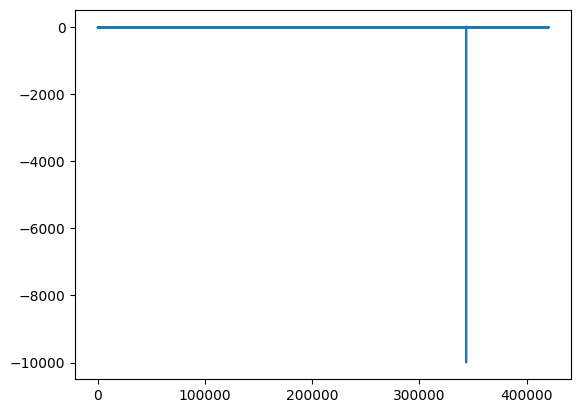

In [29]:
timeSerie = data.values

plt.plot(timeSerie)
plt.show()

In [30]:
meanReplaced = np.mean(timeSerie[0:300000])
result = np.where(timeSerie<0)[0]

for i in result:
  timeSerie[i] = meanReplaced

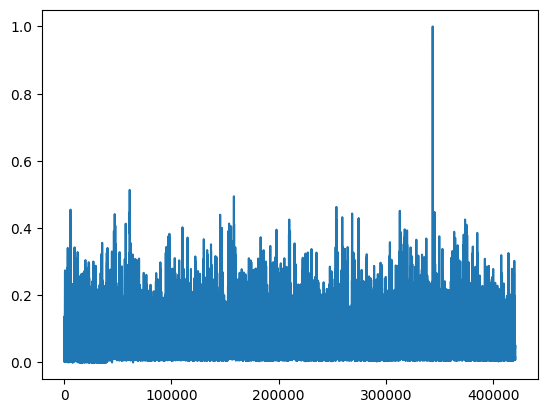

In [31]:
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))

plt.plot(timeSerie)
plt.show()

In [62]:
window = 20

X = np.zeros([len(timeSerie)-window, window])
for i in range(len(timeSerie)-window):
  X[i,:] = timeSerie[i:i+window].T
y = timeSerie[window:]

In [63]:
X.shape, y.shape

((420531, 20), (420531,))

In [64]:
#X_train = torch.from_numpy(X[0:10000].astype(np.float32)).float()
#y_train = torch.from_numpy(y[0:10000].astype(np.float32))

X_train = torch.from_numpy(X.astype(np.float32)).float()
y_train = torch.from_numpy(y.astype(np.float32))

In [65]:
X_train.shape, y_train.shape

(torch.Size([420531, 20]), torch.Size([420531]))

# **Main**

In [ ]:
path = GetPath(args['name'])
SaveParam(path, args)
SetSeed(args['seed'])

gifPloterLatentTrain = GIFPloter()
DataSaver = DataSaver_()

Model = LISV2_MLP(X_train, device=device, args=args).to(device)
if args['pretrain'] == 2: #loading pretrained model
    Model.load_state_dict(torch.load("../model/model_{}.pkl".format(args['data_name'])))
optimizer = optim.Adam(Model.parameters(), lr=args['lr'])


log/mnist-test/
start calculate sigma


In [ ]:
loss_train_history = []
loss_train1_history = []
loss_test_history = []

for epoch in range(args['epochs'] + 1):

    Model.epoch = epoch

    if epoch > 0:
        epoch_loss = Train(args, Model, X_train, y_train, optimizer, epoch)

        loss_train_history.append(epoch_loss[0])
        loss_train1_history.append(epoch_loss[1])
        #Pretrain the model encoder A, encoder B and decoder A) with reconstruction loss and GP loss
        if (epoch > args['pre_epochs'] and args['pretrain'] == 0) or args['pretrain'] == 2:
            print('hello')
            em_train = Test(args, Model, X_train, y_train, optimizer, epoch, torch_format=True)
            pred = Model.cluster(X_train).argmax(1).detach().cpu().numpy()
            for i in range(args['n_cluster']):
                if em_train[1][pred == i].shape[0] > 0:
                    Model.cluster_centers.data[i] = args['alpha'] * Model.cluster_centers.data[i] + (1-args['alpha']) * torch.mean(em_train[1][pred == i], 0)
                    print('si entre')

    if epoch == args['pre_epochs'] and (args['pretrain'] == 1 or args['pretrain'] == 0):
        em_train = Test(args, Model, X_train, y_train, optimizer, epoch)


        kmeans = KMeans(n_clusters=args['n_cluster'], random_state=0, n_init=20).fit(em_train[0])

        y_pred = kmeans.predict(em_train[0])

        cluster_centers = np.zeros((args['n_cluster'], args['clu_dim']))
        for i in range(args['n_cluster']):
            cluster_centers[i] = np.mean(em_train[1][y_pred == i], 0)
        Model.cluster_centers.data = torch.tensor(cluster_centers).to(device)

        gifPloterLatentTrain.AddNewFig(em_train[0], y_pred, path=path, name='train_epoch{}_cluster_{}.png'.format(epoch, cluster_acc(y_train.detach().cpu().numpy(), y_pred)), args=args)
        if args['pretrain'] == 1:
            torch.save(Model.state_dict(), "../model/model_{}.pkl".format(args['data_name']))


    if epoch % args['log_interval'] == 0:

        em_train = Test(args, Model, X_train, y_train, optimizer, epoch)

        y_pred = Model.cluster(X_train).argmax(1).detach().cpu().numpy()

        kmeans = KMeans(n_clusters=args['n_cluster'], random_state=0, n_init=20).fit(em_train[0])
        y_pred_vis = kmeans.predict(em_train[0])
        kmeans = KMeans(n_clusters=args['n_cluster'], random_state=0, n_init=20).fit(em_train[1])
        y_pred_clu = kmeans.predict(em_train[1])

        vis_acc = cluster_acc(y_train.detach().cpu().numpy(), y_pred_vis)
        clu_acc = cluster_acc(y_train.detach().cpu().numpy(), y_pred_clu)
        dec_acc = cluster_acc(y_train.detach().cpu().numpy(), y_pred)
        dec_nmi = nmi_score(y_train.detach().cpu().numpy(), y_pred)
        print('Train Epoch {} : {}, {}, {}, {}'.format(epoch, vis_acc, clu_acc, dec_acc, dec_nmi))

        gifPloterLatentTrain.AddNewFig(em_train[0], y_train.detach().cpu().numpy(), path=path, name='train_epoch{}_em2.png'.format(epoch), args=args)
        gifPloterLatentTrain.AddNewFig(em_train[0], y_pred_vis, path=path, name='train_epoch{}_em2_clu.png'.format(epoch), args=args)
        print('y_pred: ', y_pred )
        fig = plt.figure(figsize=(10, 8))
        #plt.scatter(em_train[0][:,0],em_train[0][:,1], c=y_pred  )
        plt.scatter(x=em_train[0][:,0], y=em_train[0][:,1], c=y_pred, s=0.3, cmap='rainbow_r' )
        plt.colorbar()
        plt.show()
        if (args['pretrain'] == 1 and epoch >= args['pre_epochs']) or (args['pretrain'] == 2 and epoch % 100 == 0 and epoch > 0):
            gifPloterLatentTrain.AddNewFig(em_train[1], y_train.detach().cpu().numpy(), path=path, name='train_epoch{}_em{}.png'.format(epoch, args['clu_dim']), args=args, cluster = Model.cluster_centers.detach().cpu().numpy())
            gifPloterLatentTrain.AddNewFig(em_train[1], y_pred, path=path, name='train_epoch{}_em{}_clu.png'.format(epoch, args['clu_dim']), args=args, cluster = Model.cluster_centers.detach().cpu().numpy())
        DataSaver.SaveData(X_train, em_train, y_train, epoch, path=path, name='train_epoch{}_'.format(str(epoch).zfill(5)))

        with open(path+"results.txt","a+") as files:
            files.write('Train Epoch {} : {}, {}, {}, {}\n'.format(epoch, vis_acc, clu_acc, dec_acc, dec_nmi))
            files.flush()

        with open("log/results.txt","a+") as files:
            files.write('{} {} {} | {} {} {} {} | Train Epoch {} : {}, {}, {}, {}\n'.format(args['perplexity'], args['batch_size'], args['ratio'][3], args['alpha'], args['sigma'], args['ratio'][4], args['vtrace_out'][1], epoch, vis_acc, clu_acc, dec_acc, dec_nmi))
            files.flush()


In [ ]:
loss_train_history = np.array(loss_train_history)
loss_train1_history = np.array(loss_train1_history)

plt.figure(figsize=(10, 5))
plt.plot(range(args['epochs']), loss_train_history, label='Loss 0')
plt.plot(range(args['epochs']), loss_train1_history, label='Loss 1')
# plt.plot(range(args['epochs']+1), loss_train_history[:, 2], label='Loss Cluster')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


# **Visualization**

In [ ]:
fig = plt.figure(figsize=(10, 10))

# Cluster: centroids
# Samples: latent

latent = em_train[1]
cluster =  Model.cluster_centers.detach().cpu().numpy()

reducer = umap.UMAP(n_neighbors=5, min_dist=0.7,  metric='correlation')
if latent.shape[0] > 20000:
    latent = latent[:10000]
    label = label[:10000]
if cluster is not None:
    latent = np.concatenate((latent, cluster), axis=0)

latent = reducer.fit_transform(latent)

#latent = np.concatenate(( em_train[1],  Model.cluster_centers.detach().cpu().numpy()), axis=0)
#PlotOtherLayer(fig, em_train[1], y_pred, args=args, cluster = Model.cluster_centers.detach().cpu().numpy())
gifPloterLatentTrain.PlotOtherLayer(fig, latent, y_pred, args, cluster=Model.cluster_centers.detach().cpu().numpy(), s=0.3)
plt.show()

NameError: name 'plt' is not defined